In [1]:
import pandas as pd

df = pd.read_csv("../data/chembl_egfr_bioactivity_clean.csv")
print(f"Data shape: {df.shape}")
df.head()


Data shape: (13474, 5)


,Smiles,Standard Value,Standard Units,pIC50,Molecule ChEMBL ID
0,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,100.00,nM,7.00,CHEMBL2448065
1,Cl.Nc1ccc2c(c1)sc1c(Nc3cccc(Br)c3)ncnc12,0.47,nM,9.33,CHEMBL539822
2,Cl.O=[N+]([O-])c1cccc2c1sc1c(Nc3cccc(Br)c3)ncnc12,158.00,nM,6.80,CHEMBL540082
3,COc1cc2ncc(C#N)c(Nc3cccc(Br)c3)c2cc1NC(=O)/C=C...,790.00,nM,6.10,CHEMBL263788
4,COc1ccc2ncncc2c1,30.00,nM,7.52,CHEMBL52472


In [2]:
from rdkit import Chem

df["mol"] = df["Smiles"].apply(Chem.MolFromSmiles)
df = df[df["mol"].notnull()]  # Drop invalid SMILES


In [3]:
from rdkit.Chem import AllChem
import numpy as np

def mol_to_fp(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

fps = [mol_to_fp(mol) for mol in df["mol"]]
X = np.array([np.array(fp) for fp in fps])
y = df["pIC50"].values

print("Feature matrix shape:", X.shape)


[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerator
[16:03:17] DEPRECATION WARNING: please use MorganGenerat

Feature matrix shape: (13474, 2048)


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
model 


RandomForestRegressor(random_state=42)

In [5]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


R² score: 0.577
RMSE: 0.946


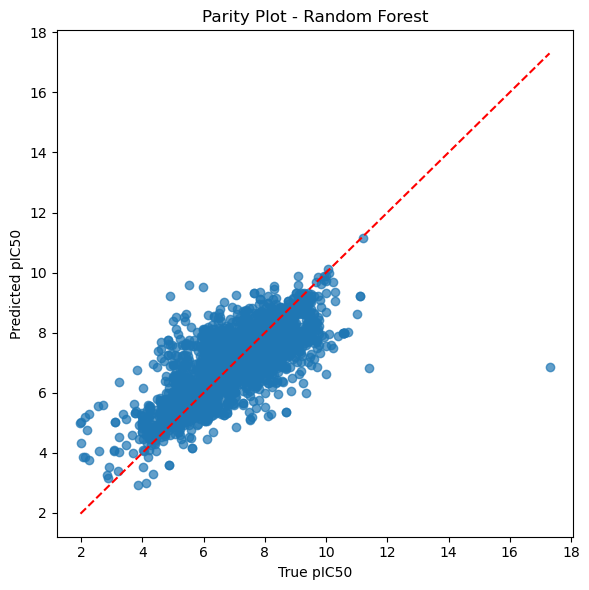

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Parity Plot - Random Forest")
plt.tight_layout()
plt.savefig("../figures/parity_plot.png", dpi=300)
plt.show()


In [7]:
import joblib
joblib.dump(model, "../models/rf_model.pkl")
print("✅ Model saved to ../models/rf_model.pkl")


✅ Model saved to ../models/rf_model.pkl


In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load cleaned data
df = pd.read_csv("../data/chembl_egfr_bioactivity_clean.csv")

# Descriptor calculation (rebuild if needed)
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 5
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
    ]

desc = df["Smiles"].apply(compute_descriptors)
desc_df = pd.DataFrame(desc.tolist(), columns=["MolWt", "LogP", "HDonors", "HAcceptors", "TPSA"])
X = desc_df.dropna()
y = df.loc[X.index, "pIC50"]

# Standardize descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model artifacts
joblib.dump(model, "../models/rf_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

# Save test data
pd.DataFrame(X_test, columns=X.columns).to_csv("../data/X_test.csv", index=False)
pd.DataFrame(y_test).to_csv("../data/y_test.csv", index=False)

print("✅ Model, scaler, and test data saved.")


✅ Model, scaler, and test data saved.
